# Import

In [1]:
import pandas as pd
import os
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os

from utils.Perspectiver import Perspectiver
from utils.Loader import CardsDataset
from arquitecture.CardsClassifier import CardClassifier
from arquitecture.SupraCardClassifier import SupraCardClassifier

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset scale testing

In [2]:
CardsDataset().data.head()

,class index,filepaths,labels,suit,category,filepaths_full
0,18,train/jack of hearts/149.jpg,jack of hearts,hearts,jack,data/train/jack of hearts/149.jpg
1,10,train/five of hearts/120.jpg,five of hearts,hearts,five,data/train/five of hearts/120.jpg
2,9,train/five of diamonds/007.jpg,five of diamonds,diamonds,five,data/train/five of diamonds/007.jpg
3,21,train/king of clubs/018.jpg,king of clubs,clubs,king,data/train/king of clubs/018.jpg
4,39,train/six of hearts/049.jpg,six of hearts,hearts,six,data/train/six of hearts/049.jpg


In [3]:
scale_1 = 1
scale_2 = 0.60
dataset_scale_100 = CardsDataset(scale=scale_1)
dataset_scale_050 = CardsDataset(scale=scale_2)

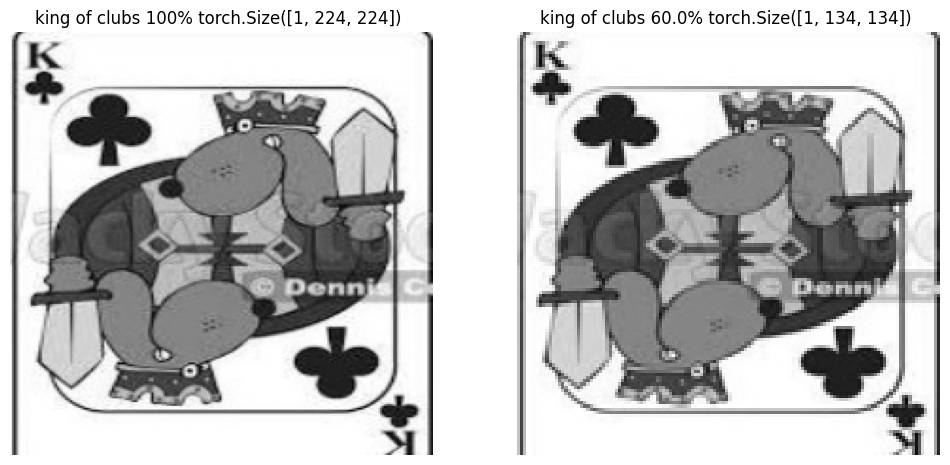

In [4]:
import random
idx = random.randint(0, len(dataset_scale_050))
img_1 , label_1 = dataset_scale_100.__getitem__(idx)
img_2 , label_2 = dataset_scale_050.__getitem__(idx)
Perspectiver.plotComparison(imageBefore = Perspectiver.grayscale_to_rgb(img_1.numpy()[0]) , 
                            imageAfter = Perspectiver.grayscale_to_rgb(img_2.numpy()[0]) , 
                            titleBefore = f"{dataset_scale_100.decode_label(label_1)} {scale_1*100}% {img_1.size()} ",
                            titleAfter = f"{dataset_scale_050.decode_label(label_2)} {scale_2*100}% {img_2.size()} "
                            )

# Training process

## Hyperparameters

In [2]:
EPOCH = 300
BATCH_SIZE = 2400
NUN_WORKERS = 12
LR = 0.0004

classifier = SupraCardClassifier(convolution_structure=[1,8,8,16,16,32,32,64,64], 
                            image_size=torch.Size((134, 134)), 
                            expert_output_len=8, 
                            extractors_output_len=10,
                            expert_depth=4,
                            output_len=53,
                            n_extractor=2
                            ).to(DEVICE) # 0.52, 20034987

classifier = SupraCardClassifier(convolution_structure=[1,16,16,16,16,32,32,32,32], 
                            image_size=torch.Size((134, 134)), 
                            expert_output_len=8, 
                            extractors_output_len=10,
                            expert_depth=8,
                            output_len=53,
                            n_extractor=2
                            ).to(DEVICE) # 0.35, 5362811

classifier = SupraCardClassifier(convolution_structure=[1,16,16,16,16,32,32,32,32], 
                            image_size=torch.Size((134, 134)), 
                            expert_output_len=15, 
                            extractors_output_len=30,
                            expert_depth=8,
                            output_len=53,
                            n_extractor=2
                            ).to(DEVICE) #0.4264, 6425575

classifier = SupraCardClassifier(convolution_structure=[1,16,16,16,16,32,32,32,32], 
                            image_size=torch.Size((134, 134)), 
                            expert_output_len=15, 
                            extractors_output_len=32,
                            expert_depth=8,
                            output_len=53,
                            n_extractor=2
                            ).to(DEVICE) #0.4764, 6427039

In [6]:
csv_file = "cards.csv"
target = "suit"

train_dataset = CardsDataset(scale=0.6, split="train", csv_file=csv_file, target=target)
test_dataset = CardsDataset(scale=0.6, split="test")
valid_dataset = CardsDataset(scale=0.6, split="valid", csv_file=csv_file, target=target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)

_, label = test_dataset.__getitem__(1)

classifier = CardClassifier(image_size=torch.Size((134, 134)), 
                            convolution_structure=[1,8,8,16,16,24,24,32,32],
                            expert_output_len=1,
                            expert_depth=4,
                            output_len=len(label),
                            pool_depth=2
                            ).to(DEVICE)

#classifier = SupraCardClassifier(convolution_structure=[1,8,8,16,16,24,24,32,32], 
#                            image_size=torch.Size((134, 134)), 
#                            expert_output_len=3, 
#                            extractors_output_len=10,
#                            expert_depth=4,
#                            output_len=len(label),
#                            n_extractor=2,
#                            pool_depth=2
#                            ).to(DEVICE)


print(classifier.n_parameters())

2374014


In [7]:
criterion = nn.CrossEntropyLoss(reduction = "sum")

optimizer = optim.Adam(classifier.parameters(), lr=LR)

os.makedirs(f"models/checkpoints/", exist_ok=True)

In [3]:
def save_checkpoint(model, epoch, optimizer, loss, name):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f"models/checkpoints/{name}.pth")

def validation(model, valid_loader, criterion, device):
        valid_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, torch.argmax(labels.to(device), dim=1))
                valid_loss += loss.item() * inputs.size(0)
                
                x, preds = torch.max(outputs, dim=1)
                correct += (preds == torch.argmax(labels.to(device), dim=1)).sum().item()
        
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_prec = correct / len(valid_loader.dataset)

        return valid_loss, valid_prec

In [4]:
def training(model, optimizer, criterion, train_loader, valid_loader, name, device, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, torch.argmax(labels.to(device), dim=1))
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        model.eval()

        max_prec = 0
        valid_loss, valid_prec = validation(model, valid_loader, criterion, device)
        if valid_prec > max_prec:
            save_checkpoint(model, epoch, optimizer, loss, name)
            max_prec = valid_prec
        
        print(f"EPOCH {epoch+1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {valid_loss:.4f} - Validation Precision: {valid_prec:.4f}")

In [12]:
training(model=classifier, 
         optimizer=optimizer, 
         criterion=criterion,
         train_loader=train_loader,
         valid_loader=valid_loader,
         name="suit_classifier_checkpoint",
         device=DEVICE,
         epoch=EPOCH
         )

EPOCH 1/300 - Training Loss: 9057.5421 - Validation Loss: 1066.6042 - Validation Precision: 0.0000
EPOCH 2/300 - Training Loss: 8998.1420 - Validation Loss: 1066.2866 - Validation Precision: 0.0000
EPOCH 3/300 - Training Loss: 8953.7979 - Validation Loss: 1065.8898 - Validation Precision: 0.0000
EPOCH 4/300 - Training Loss: 8908.3888 - Validation Loss: 1065.4934 - Validation Precision: 0.0000
EPOCH 5/300 - Training Loss: 8863.5821 - Validation Loss: 1065.1006 - Validation Precision: 0.0000
EPOCH 6/300 - Training Loss: 8818.5095 - Validation Loss: 1064.7145 - Validation Precision: 0.0000
EPOCH 7/300 - Training Loss: 8770.6046 - Validation Loss: 1064.3341 - Validation Precision: 0.0000
EPOCH 8/300 - Training Loss: 8726.0349 - Validation Loss: 1063.9598 - Validation Precision: 0.0000
EPOCH 9/300 - Training Loss: 8679.6123 - Validation Loss: 1063.3013 - Validation Precision: 0.0000
EPOCH 10/300 - Training Loss: 8630.9718 - Validation Loss: 1060.9899 - Validation Precision: 0.0000
EPOCH 11/

In [5]:
csv_file = "cards.csv"
target = "category"

train_dataset = CardsDataset(scale=0.6, split="train", csv_file=csv_file, target=target)
test_dataset = CardsDataset(scale=0.6, split="test")
valid_dataset = CardsDataset(scale=0.6, split="valid", csv_file=csv_file, target=target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)

_, label = test_dataset.__getitem__(1)

classifier = CardClassifier(image_size=torch.Size((134, 134)), 
                            convolution_structure=[1,8,8,16,16,24,24,32,32],
                            expert_output_len=1,
                            expert_depth=4,
                            output_len=len(label),
                            pool_depth=2
                            ).to(DEVICE)

print(classifier.n_parameters())

2374014


In [ ]:
criterion = nn.CrossEntropyLoss(reduction = "sum")

optimizer = optim.Adam(classifier.parameters(), lr=LR)

training(model=classifier, 
         optimizer=optimizer, 
         criterion=criterion,
         train_loader=train_loader,
         valid_loader=valid_loader,
         name="category_classifier_checkpoint",
         device=DEVICE,
         epochs=(EPOCH*2)
         )

TypeError: training() got an unexpected keyword argument 'epoch'